In [22]:
import gzip
import numpy as np
import pandas as pd
from time import time

from sklearn.metrics import confusion_matrix
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard, LearningRateScheduler

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import seaborn_image as isns
sns.set()

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.8_3.8.1776.0_x64__qbz5n2kfra8p0\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The validate_legend_loc function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


In [120]:
def read_mnist(images_path: str, labels_path: str):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

In [121]:
train = {}
test = {}

gz_dir = '../input/mnist'
train['features'], train['labels'] = read_mnist(f'{gz_dir}/train-images-idx3-ubyte.gz', 
                                                f'{gz_dir}/train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_mnist(f'{gz_dir}/t10k-images-idx3-ubyte.gz', 
                                              f'{gz_dir}/t10k-labels-idx1-ubyte.gz')

## LeNet-5
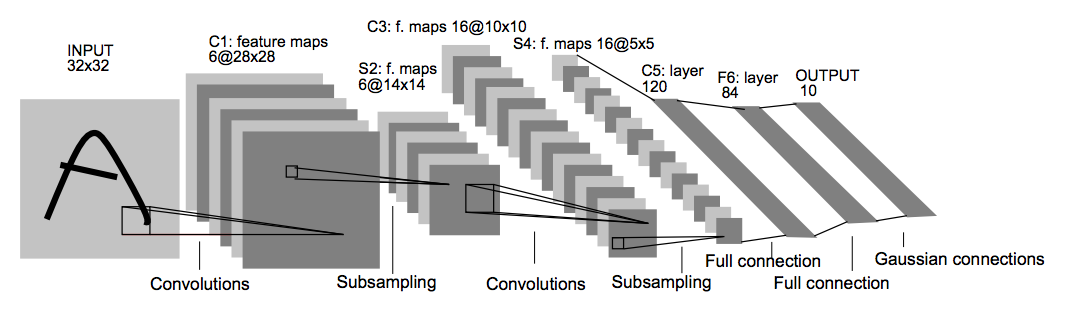

In [179]:
def get_model():
    model = Sequential()

    model.add(layers.Conv2D(32, kernel_size=3,activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, kernel_size=3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, kernel_size=3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, kernel_size=3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(10, activation='softmax'))
    return model

In [6]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0

In [7]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [8]:
EPOCHS = 25
BATCH_SIZE = 128

In [9]:
X_train, y_train = train['features'], to_categorical(train['labels'])
train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)

In [10]:
print('# of training images:', train['features'].shape[0])

annealer = LearningRateScheduler(lambda epoch, x: 1e-3 * 0.95 ** (x + epoch))
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
          callbacks=[annealer])

# of training images: 60000
Epoch 1/25
468/468 [==============================] - 136s 288ms/step - loss: 0.5807 - accuracy: 0.8230
Epoch 2/25
468/468 [==============================] - 158s 338ms/step - loss: 0.0708 - accuracy: 0.9787
Epoch 3/25
468/468 [==============================] - 193s 412ms/step - loss: 0.0474 - accuracy: 0.9850
Epoch 4/25
468/468 [==============================] - 160s 343ms/step - loss: 0.0391 - accuracy: 0.9877
Epoch 5/25
468/468 [==============================] - 180s 385ms/step - loss: 0.0333 - accuracy: 0.9897
Epoch 6/25
468/468 [==============================] - 176s 376ms/step - loss: 0.0286 - accuracy: 0.9906
Epoch 7/25
468/468 [==============================] - 181s 386ms/step - loss: 0.0291 - accuracy: 0.9916
Epoch 8/25
468/468 [==============================] - 180s 384ms/step - loss: 0.0255 - accuracy: 0.9924
Epoch 9/25
468/468 [==============================] - 179s 383ms/step - loss: 0.0234 - accuracy: 0.9925
Epoch 10/25
468/468 [===============

In [11]:
score = model.evaluate(test['features'], to_categorical(test['labels']))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 5s 14ms/step - loss: 0.0160 - accuracy: 0.9955
Test loss: 0.016009200364351273
Test accuracy: 0.9955000281333923


In [122]:
y_pred = model.predict(test['features'])
matrix = confusion_matrix(to_categorical(test['labels']).argmax(axis=1), y_pred.argmax(axis=1))

In [129]:
def display_image(position):
    image = train['features'][position].squeeze()
    plt.title('Example %d. Label: %d' % (position, train['labels'][position]))
    plt.imshow(image, cmap=plt.cm.gray_r, origin='upper')

In [134]:
def display_img_table(images):
    g = isns.ImageGrid(images, cmap=plt.cm.gray_r, col_wrap=10, step=10, origin='upper')

In [174]:
confusion_img_matrix = np.full((10, 10, 2), -1.)
for i, (actual, pred) in enumerate(zip(test['labels'], y_pred)):
    for j in range(len(pred)):
        if pred[j] > confusion_img_matrix[actual][j][0]:
            confusion_img_matrix[actual][j] = [pred[j], i]

In [176]:
matrix

array([[ 979,    0,    0,    0,    0,    0,    0,    1,    0,    0],
       [   0, 1132,    0,    0,    0,    0,    1,    2,    0,    0],
       [   0,    0, 1028,    0,    0,    0,    0,    4,    0,    0],
       [   0,    0,    1, 1005,    0,    4,    0,    0,    0,    0],
       [   0,    0,    0,    0,  977,    0,    0,    0,    0,    5],
       [   0,    0,    0,    4,    0,  887,    1,    0,    0,    0],
       [   3,    2,    0,    0,    0,    0,  953,    0,    0,    0],
       [   0,    2,    1,    0,    0,    0,    0, 1024,    0,    1],
       [   1,    0,    2,    0,    0,    0,    0,    0,  970,    1],
       [   0,    0,    0,    0,    4,    2,    0,    2,    1, 1000]],
      dtype=int64)

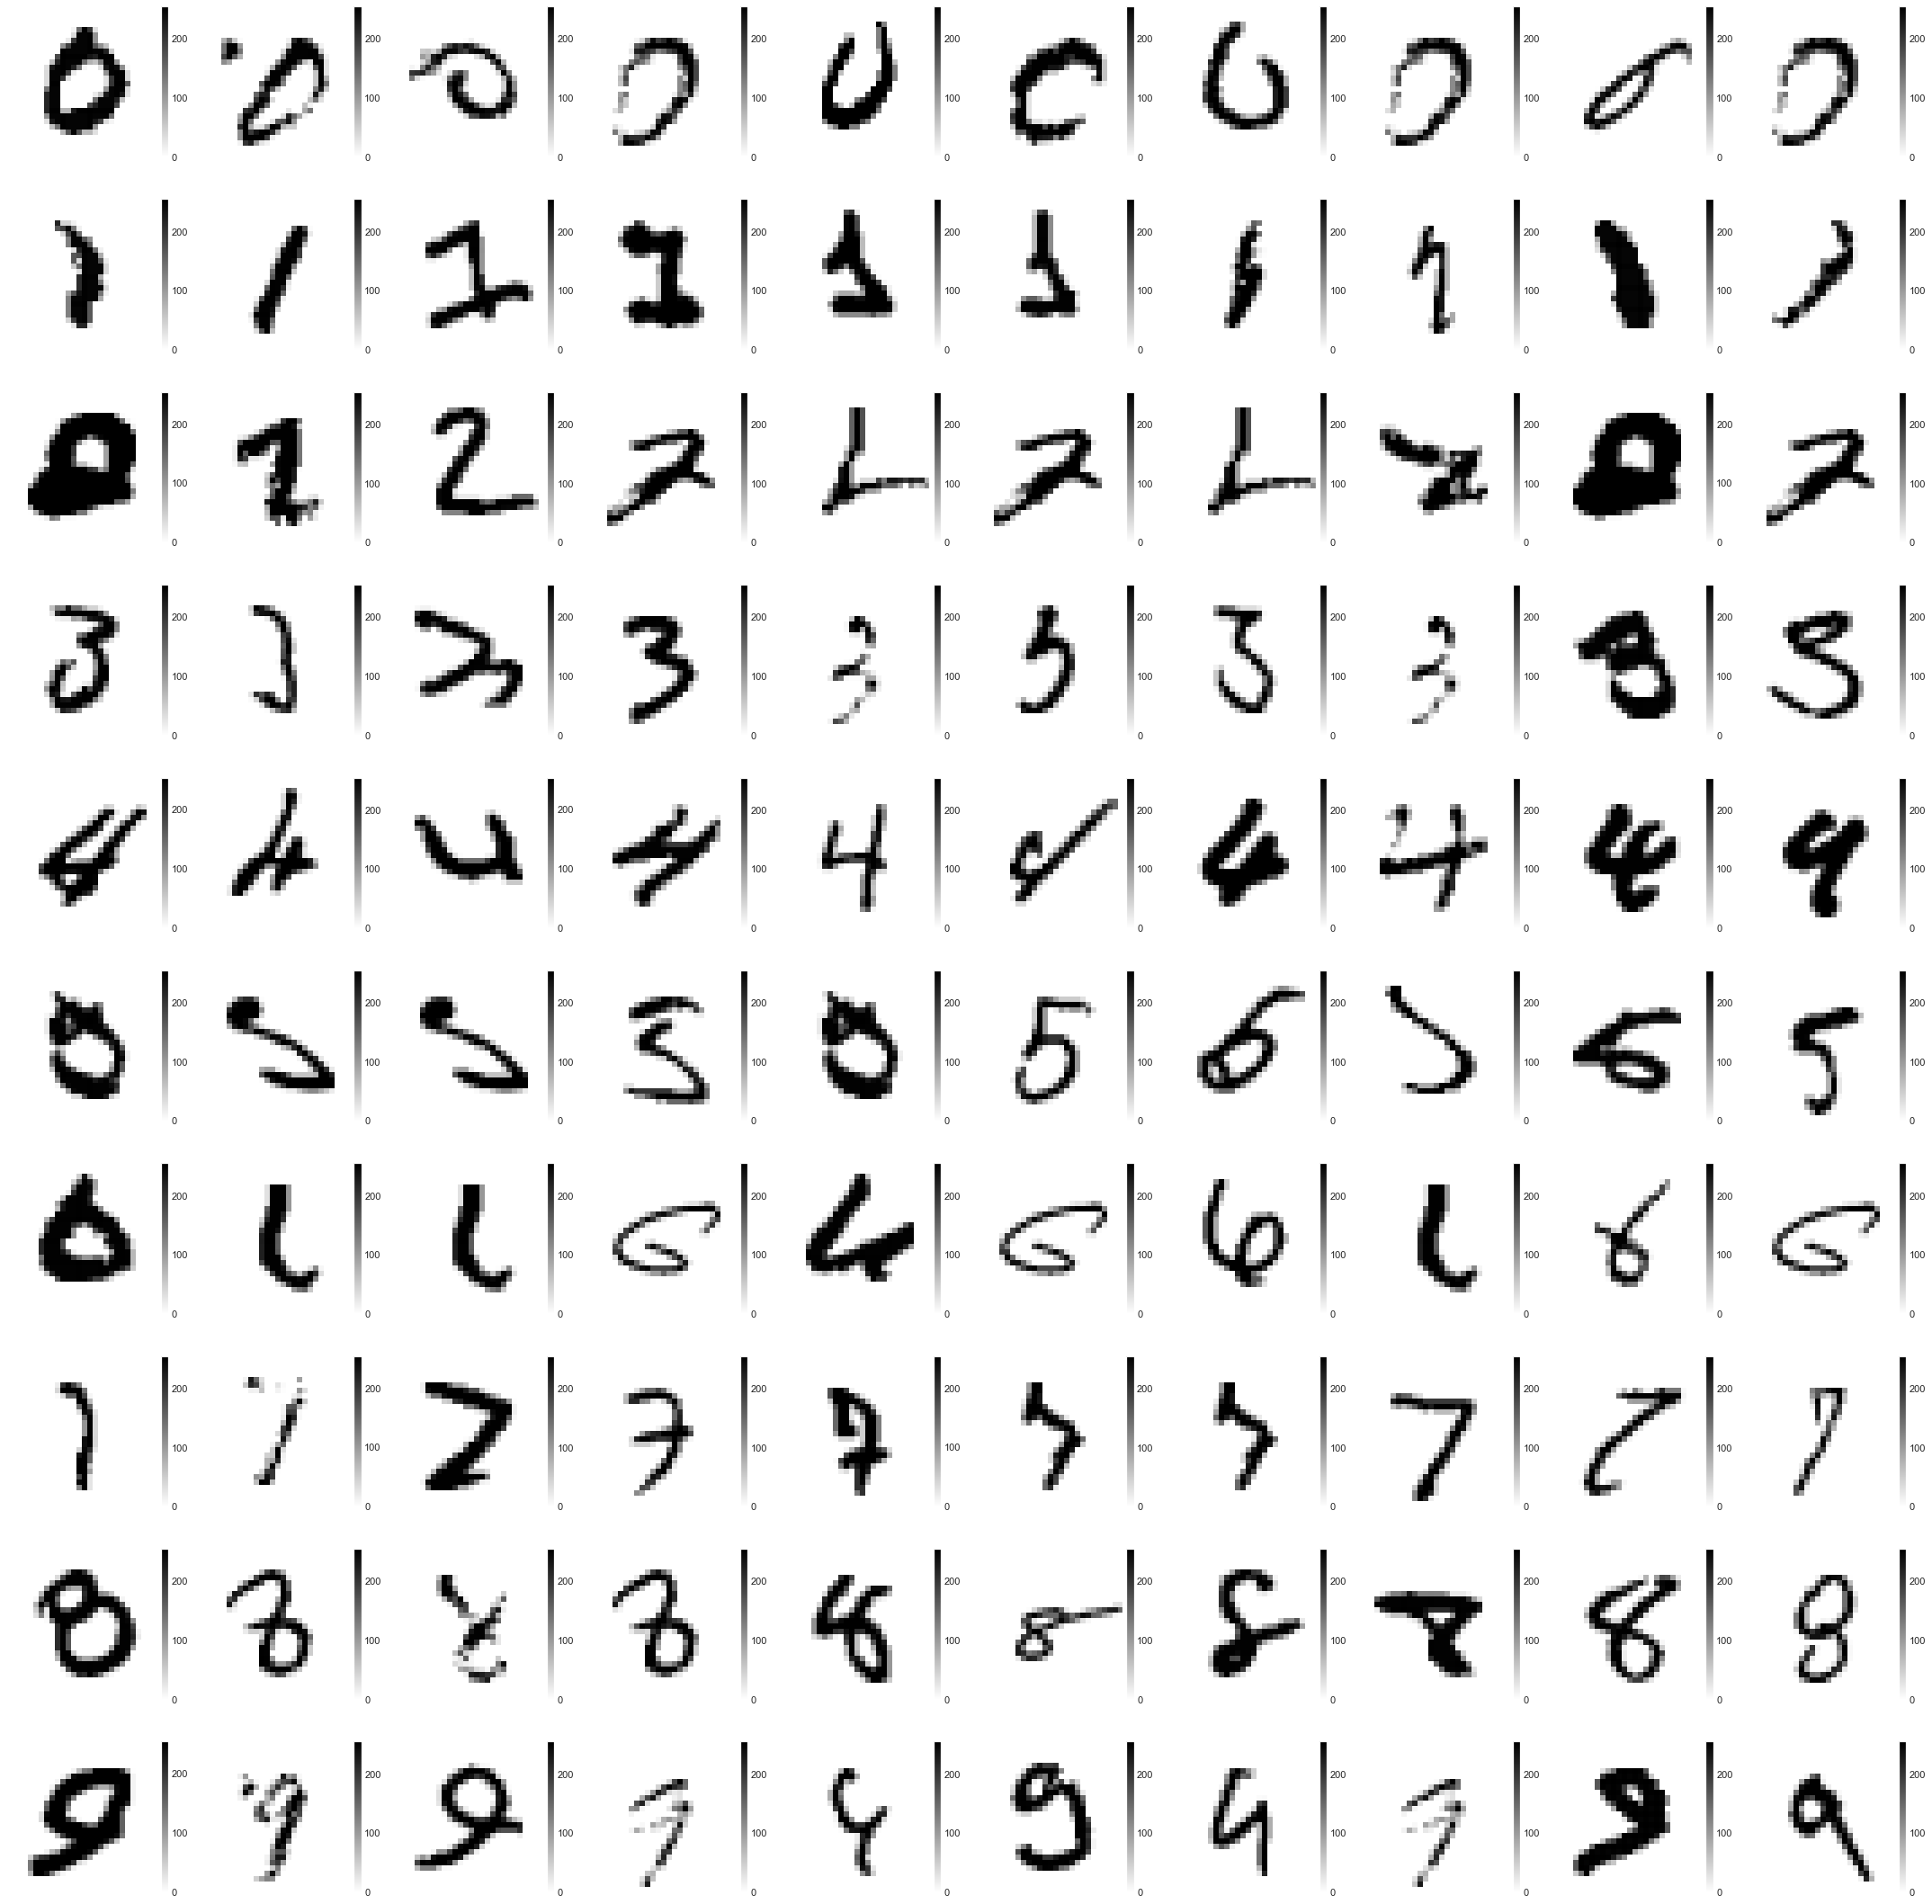

In [175]:
matrix_images = test['features'][[int(confusion_img_matrix[i][j][1]) for i in range(10) for j in range(10)]]
display_img_table([img.squeeze() for img in matrix_images])

### Test accuracies
- Original LeNet-5: 0.9853000044822693
- LeNet-5 with AveragePooling and 3x3 kernels: 0.9857000112533569
- LeNet-5 with AveragePooling, 3x3 kernels and additional full-connected layer: 0.987500011920929
- LeNet on steroids: 0.9955000281333923

## Fashion-MNIST

In [177]:
train = {}
test = {}

gz_dir = '../input/fashion-mnist'
train['features'], train['labels'] = read_mnist(f'{gz_dir}/train-images-idx3-ubyte.gz', 
                                                f'{gz_dir}/train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_mnist(f'{gz_dir}/t10k-images-idx3-ubyte.gz', 
                                              f'{gz_dir}/t10k-labels-idx1-ubyte.gz')

In [178]:
X_train, y_train = train['features'], to_categorical(train['labels'])
train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)

In [ ]:
model = get_model()
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [180]:
EPOCHS = 25
BATCH_SIZE = 128

In [181]:
X_train, y_train = train['features'], to_categorical(train['labels'])
train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)

In [182]:
print('# of training images:', train['features'].shape[0])

annealer = LearningRateScheduler(lambda epoch, x: 1e-3 * 0.95 ** (x + epoch))
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
          callbacks=[annealer])

# of training images: 60000
Epoch 1/25
468/468 [==============================] - 160s 341ms/step - loss: 0.5375 - accuracy: 0.8235
Epoch 2/25
468/468 [==============================] - 157s 335ms/step - loss: 0.3145 - accuracy: 0.8845
Epoch 3/25
468/468 [==============================] - 127s 271ms/step - loss: 0.2724 - accuracy: 0.9018
Epoch 4/25
468/468 [==============================] - 135s 288ms/step - loss: 0.2464 - accuracy: 0.9105
Epoch 5/25
468/468 [==============================] - 137s 292ms/step - loss: 0.2292 - accuracy: 0.9164
Epoch 6/25
468/468 [==============================] - 154s 329ms/step - loss: 0.2135 - accuracy: 0.9221
Epoch 7/25
468/468 [==============================] - 147s 314ms/step - loss: 0.2031 - accuracy: 0.9263
Epoch 8/25
468/468 [==============================] - 162s 346ms/step - loss: 0.1907 - accuracy: 0.9312
Epoch 9/25
468/468 [==============================] - 148s 316ms/step - loss: 0.1800 - accuracy: 0.9350
Epoch 10/25
468/468 [===============

In [183]:
score = model.evaluate(test['features'], to_categorical(test['labels']))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 10ms/step - loss: 0.2372 - accuracy: 0.9288
Test loss: 0.23723872005939484
Test accuracy: 0.9287999868392944


In [184]:
y_pred = model.predict(test['features'])
matrix = confusion_matrix(to_categorical(test['labels']).argmax(axis=1), y_pred.argmax(axis=1))

In [187]:
confusion_img_matrix = np.full((10, 10, 2), -1.)
for i, (actual, pred) in enumerate(zip(test['labels'], y_pred)):
    for j in range(len(pred)):
        if pred[j] > confusion_img_matrix[actual][j][0]:
            confusion_img_matrix[actual][j] = [pred[j], i]

In [188]:
matrix

array([[900,   0,  13,   8,   1,   1,  66,   0,  11,   0],
       [  3, 984,   0,   7,   1,   0,   3,   0,   2,   0],
       [ 12,   0, 934,   9,  16,   0,  29,   0,   0,   0],
       [ 11,   2,  12, 938,  18,   0,  18,   0,   1,   0],
       [  0,   0,  78,  20, 850,   0,  50,   0,   2,   0],
       [  0,   0,   0,   0,   0, 989,   0,   6,   0,   5],
       [109,   0,  57,  19,  47,   0, 760,   0,   8,   0],
       [  0,   0,   0,   0,   0,   4,   0, 986,   0,  10],
       [  1,   0,   1,   4,   0,   2,   0,   1, 991,   0],
       [  0,   0,   0,   0,   0,   5,   0,  39,   0, 956]], dtype=int64)

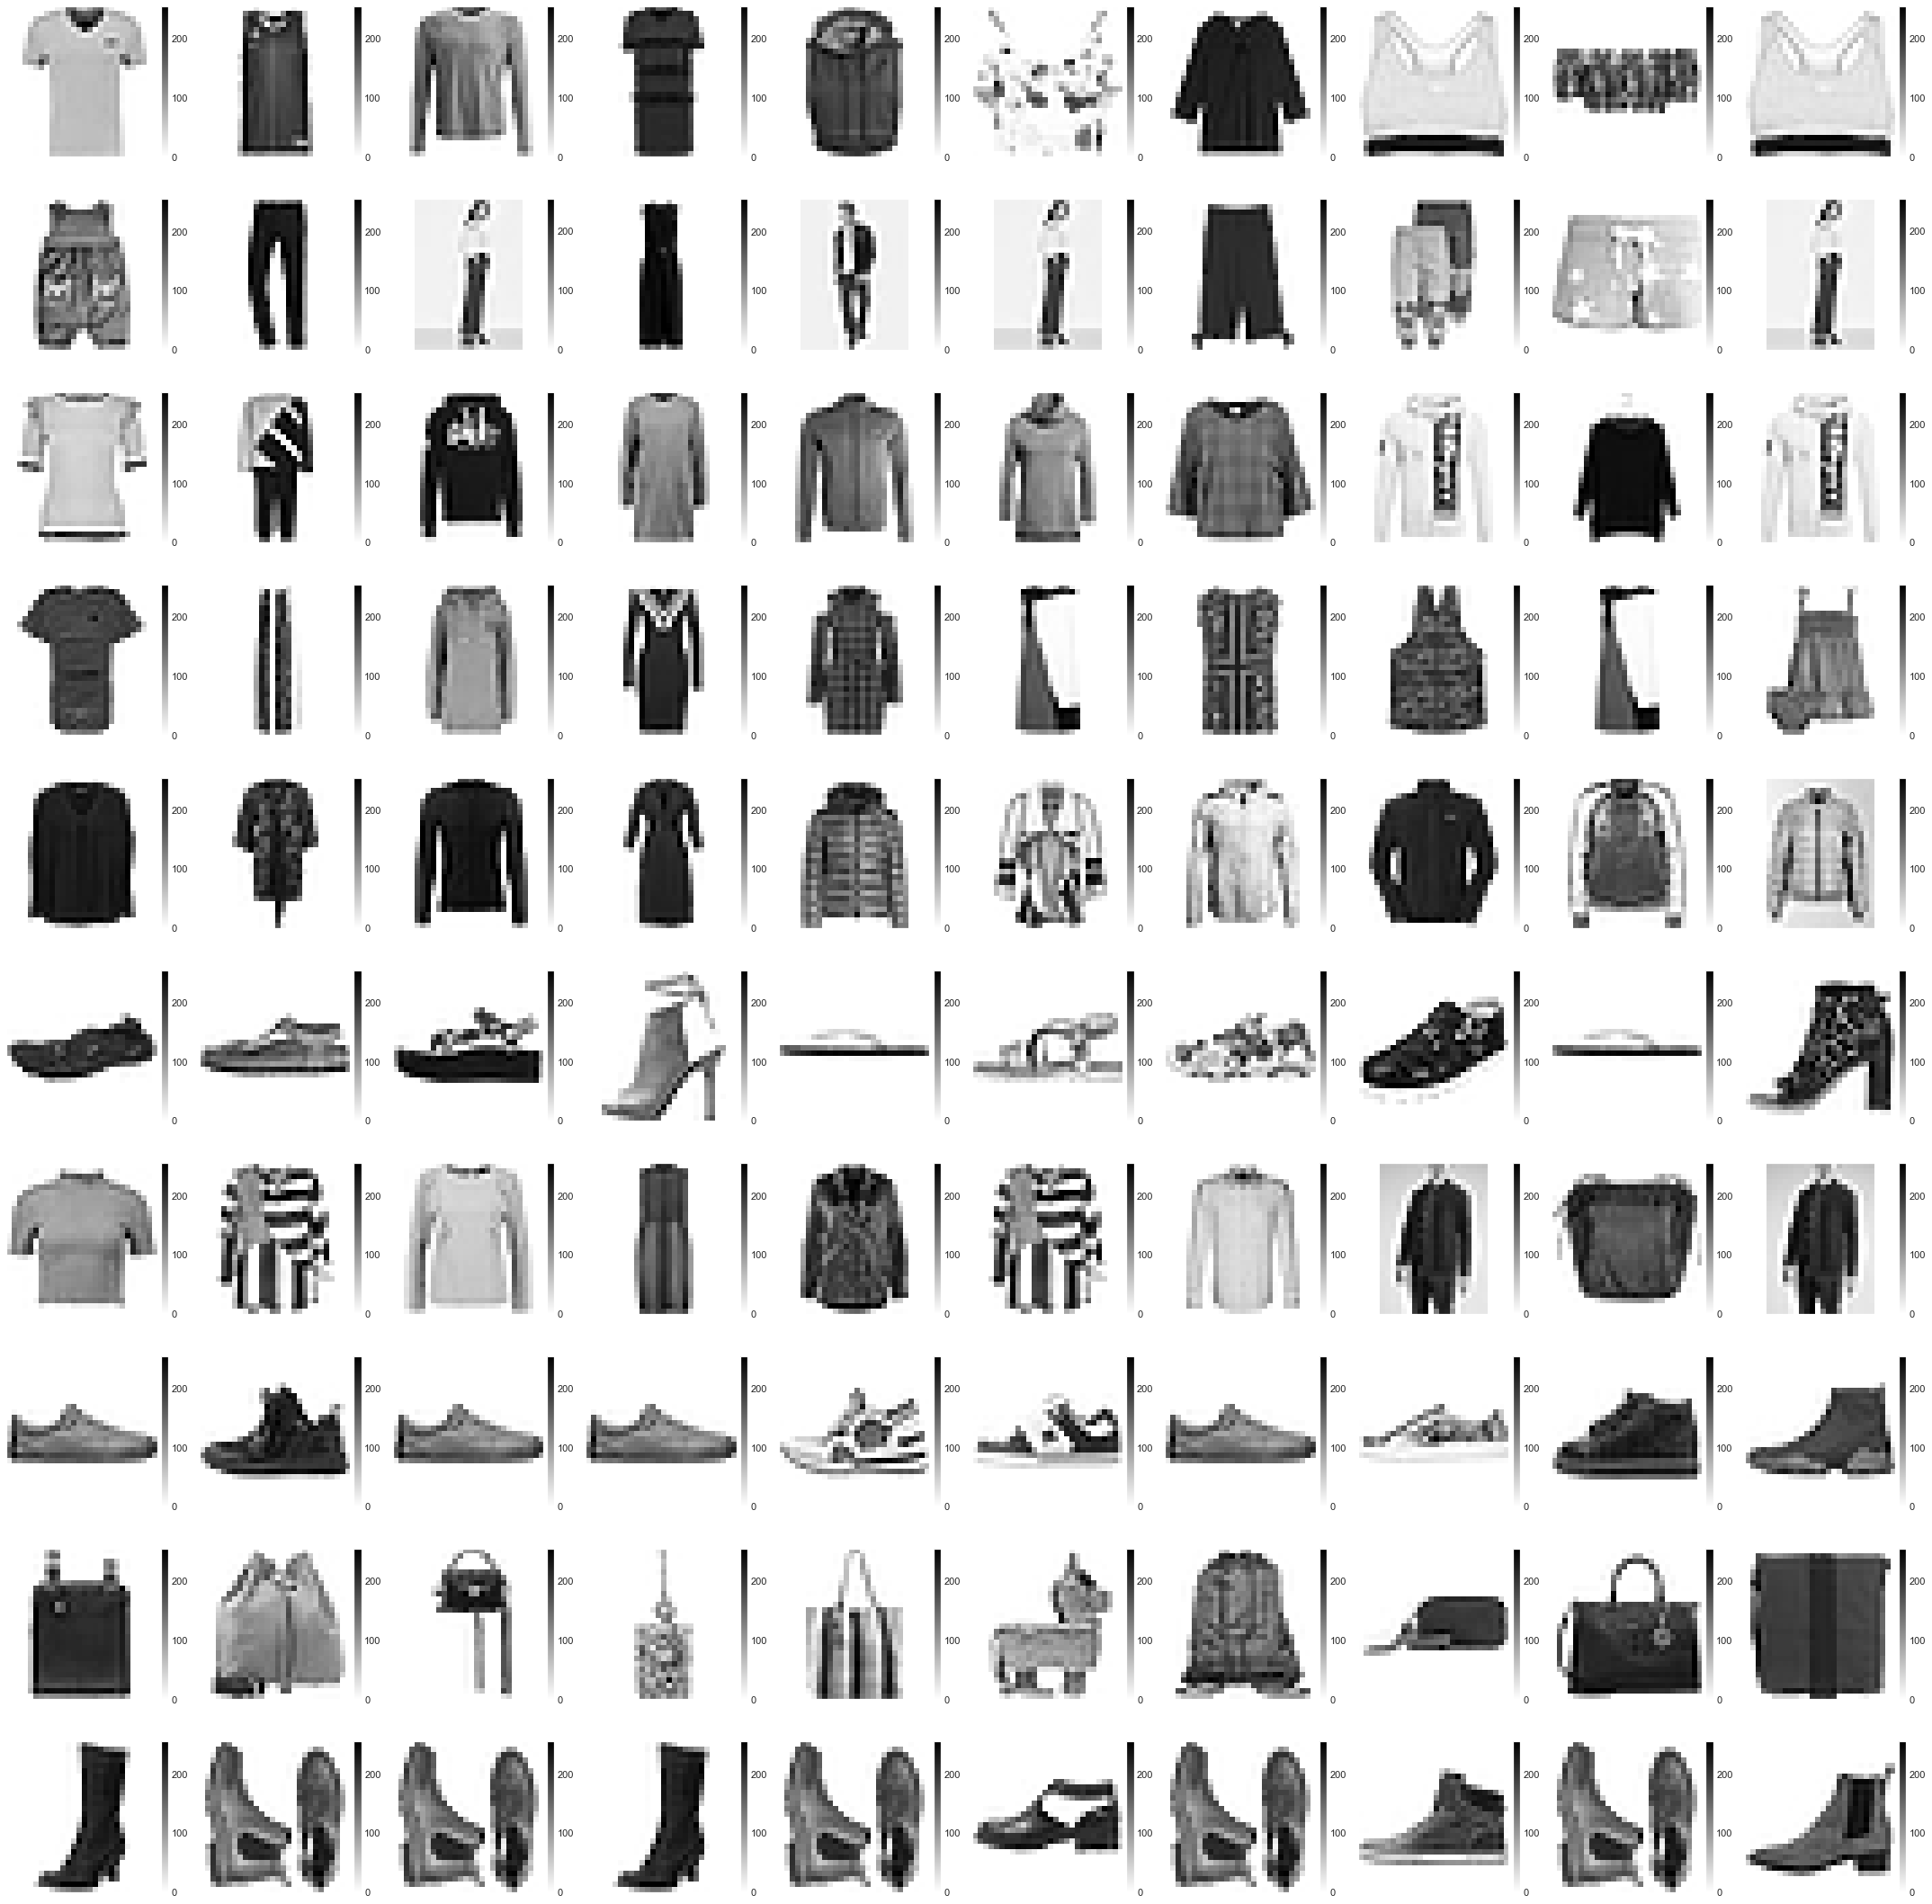

In [189]:
matrix_images = test['features'][[int(confusion_img_matrix[i][j][1]) for i in range(10) for j in range(10)]]
display_img_table([img.squeeze() for img in matrix_images])